# TestingEvaluateClass

# Libraries

In [1]:
# directory set up 
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# data attainment
import pandas as pd

# mathematical
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Extra_Work.PythonFiles.preprocessing import scale_data

# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dense, Dropout

# evaluation
from Extra_Work.PythonFiles.modelling import evaluate_models
from Extra_Work.PythonFiles.modelling import FeedForward

# plotting
import matplotlib.pyplot as plt

# setting global seeds
tf.random.set_seed(1)
np.random.seed(1)

# Data

In [2]:
# load data

df = pd.read_csv('../Data/dataset2.csv')

X, scalers = scale_data(df[df.columns[:-1]], mode = 'robust')
#X['Spring constant (N per m)'] = 0
#X['Ball radius (mm)'] = 0

y = df[df.columns[-1]]

y_binary = to_categorical(y)

data = train_test_split(
    X,y_binary, test_size = 0.8, random_state = 23
)



In [3]:
X.head(5)

,Arm length (m),Ball weight (kg),Ball radius (mm),Air temperature (deg C),Spring constant (N per m),Device weight (kg)
0,0.079666,0.047542,-0.446794,0.000000,0.105246,0.448768
1,-0.780138,0.580440,-0.258312,0.833333,-0.240471,-0.967384
2,-1.187167,0.887401,0.491511,1.166667,2.949108,0.207340
3,-1.210137,0.807060,0.145161,-0.500000,-0.093714,0.758441
4,-1.619550,1.149810,0.861926,0.000000,2.101938,0.411803


In [12]:
y_binary

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

# Data Exploration

# Model Cell

In [81]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.activations import elu, relu 
from tensorflow.keras.layers import Activation
# add automation to this
def uncompiled_model():
    inputs = Input(shape=(6,), name='Data')
    
    x = Dense(16, activation = 'relu')(inputs)
    #x = Dropout(0.2)(x)

    # try adding weight constraints to model
    x = BatchNormalization()(x)
    x = Dense(8, activation='relu')(x)
    x = BatchNormalization()(x)


    x = Dense(16, activation='relu')(x)





    # and make sure that epochs = 250
    # update, best is 16,8,16 with batch = 50, epochs = 250
    # also 32,16,32
    
    x = Dense(4, activation='sigmoid')(x)
    outputs = Dense(2, activation='softmax')(x)




    #outputs = Dense(2, activation='sigmoid', name='TargetHit')(x)
    # remember, you might have to make ur output a sigmoid!


    # chris model
    #x = Dense(3, activation='linear')(inputs)
    #outputs = Dense(2, activation = 'sigmoid')(x)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# will get penalised for model complexity, make sure you decrease this

def compile_model():
    model = uncompiled_model()
    model.compile(
        optimizer="adam", # next step, add custom optimizers and modify learning 
        # rates. Adam yelds the best values
        loss="binary_crossentropy", # binary_crossentropy
        metrics=["accuracy",
                 "binary_accuracy",
                 "binary_crossentropy",
                 "categorical_accuracy"
                 ],
    )
    return model

def compiler(model):
    model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy",
             "binary_accuracy",
             "binary_crossentropy",
             "categorical_accuracy"
             ],
    )
    return model
    

# Test Model

In [5]:
feedforward = FeedForward()


In [6]:
model = compile_model()
instance = evaluate_models(
    uncompiled_model(), compiler, *data
)

scores, histories = instance.cross_validate(epochs = 100, verbose = 0)


25/25 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8325 - binary_accuracy: 0.8319 - binary_crossentropy: 0.4103 - categorical_accuracy: 0.8325
average loss:  0.44904146790504457
average accuracy:  0.8014999985694885


[0.74250001 0.80124998 0.80500001 0.82625002 0.83249998]


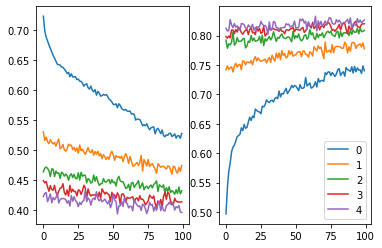

In [7]:
instance.plot_histories(histories)
print(np.asarray(scores)[:,1])

In [71]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 10)

from sklearn.model_selection import KFold
from time import time
def cross_validate(K = 5, **kwargs):
    scores = []
    histories = []
    X = np.concatenate((data[0], data[1]), axis = 0)
    y = np.concatenate((data[2], data[3]), axis = 0)
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model()
        start = time()
        histories.append(model.fit(X[train], y[train], **kwargs).history)
        print(time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0))
    print("average loss: ", np.asarray(scores)[:,0].mean())
    print("average accuracy: ", np.asarray(scores)[:,1].mean()) # make sure that accuracy is the first metric in compile
    print(model.summary())
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy']):
    fig, axes = plt.subplots(nrows = len(metrics) % 2 + 1, ncols = 2)
    axes = axes.reshape(len(metrics) % 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
        plt.legend([i for i in range(len(histories))])
        


In [83]:
scores, histories = cross_validate(K = 5, 
                                   epochs = 250,
                                   verbose = 0,
                                   batch_size = 50,
                                   shuffle = True) 
#validation_split = 0.1, callbacks = [early_stopping]) #)
print(scores)

20.553028106689453
20.01839780807495
19.919700860977173
20.114791870117188
21.92816424369812
average loss:  0.37895347476005553
average accuracy:  0.8377499938011169
Model: "functional_206"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_356 (Dense)            (None, 16)                112       
_________________________________________________________________
batch_normalization_162 (Bat (None, 16)                64        
_________________________________________________________________
dense_357 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_163 (Bat (None, 8)                 32        
_________________________________________________________________
dense_358 (Dense) 

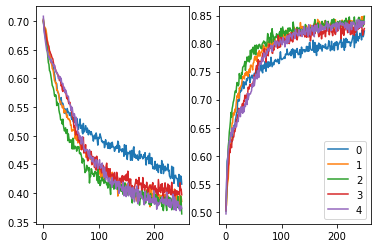

In [82]:
plot_histories(histories)

In [77]:
# testing with validation split
model = compile_model()
start = time()
history = model.fit(X,y_binary,
                    shuffle = True, validation_split = 0.2,
                    epochs = 250, verbose = 0, batch_size = 50)
model.summary()

Model: "functional_186"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_306 (Dense)            (None, 16)                112       
_________________________________________________________________
batch_normalization_142 (Bat (None, 16)                64        
_________________________________________________________________
dense_307 (Dense)            (None, 8)                 136       
_________________________________________________________________
batch_normalization_143 (Bat (None, 8)                 32        
_________________________________________________________________
dense_308 (Dense)            (None, 16)                144       
_________________________________________________________________
dense_309 (Dense)            (None, 2)              

125/125 [==============================] - 0s 2ms/step - loss: 0.3505 - accuracy: 0.8605 - binary_accuracy: 0.8605 - binary_crossentropy: 0.3505 - categorical_accuracy: 0.8605


[0.35052692890167236,
 0.8604999780654907,
 0.8604999780654907,
 0.35052692890167236,
 0.8604999780654907]

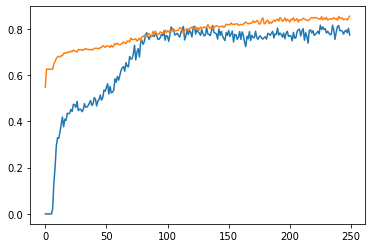

In [79]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
model.evaluate(X,y_binary)

In [12]:
instance.evaluate(epochs = 100, verbose = 0)


100/100 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.8059 - binary_accuracy: 0.8067 - binary_crossentropy: 0.4429 - categorical_accuracy: 0.8059


In [13]:
feedforward.print_params(-3)

[[0.442889928817749, 0.8059375286102295, 0.8067187666893005, 0.442889928817749, 3.5885000228881836, 482]]


In [14]:
#feedforward.plot_model()

In [15]:
#model = feedforward.get_model()
#yhat = model.predict(X_test)
#yhat = yhat[:,1]
#yhat[yhat > 0.5] = 1
#yhat[yhat <=0.5] = 0

In [16]:
#(yhat == y_test[:,1]).sum()/len(yhat)

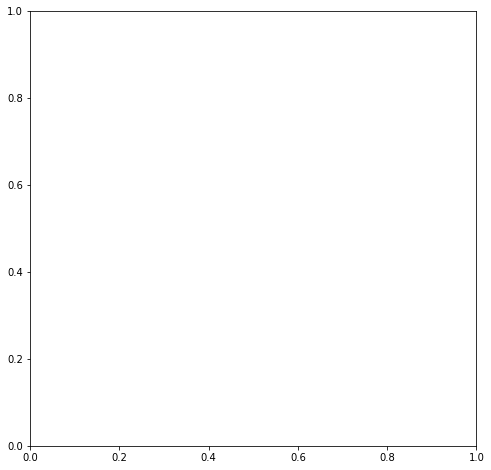

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,8))
plt.show()

2
{'figsize': (8, 8)}


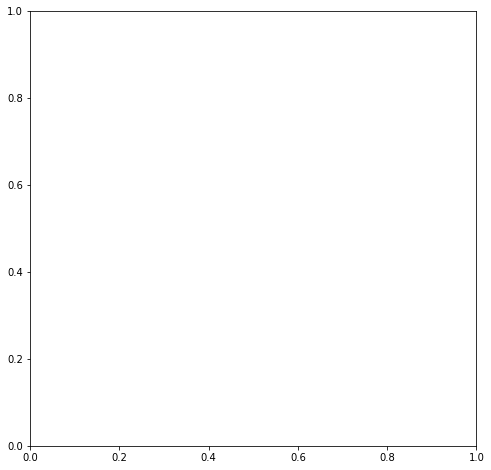

In [18]:
def function(*args, K = 5,**kwargs):
    print(args) if not args else print(args[0])
    print(kwargs)
    fig, ax = plt.subplots(**kwargs)
    plt.show()
    
function(2,figsize = (8,8))

https://dbader.org/blog/meaning-of-underscores-in-python

https://keras.io/api/layers/initializers/

https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://ruder.io/optimizing-gradient-descent/

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

https://github.com/keras-team/keras/pull/9965

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html


https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd


https://www.quora.com/What-is-the-importance-of-the-validation-split-variable-in-Keras



In [93]:
# idea: run the model for different values and parameters and then use regression / calssification to find the best ones

# apparently having a small middle layer is good?